# GNN Training for Water Network Leak Detection

This notebook trains a Graph Neural Network (GNN) to identify the leaking pipe in a Water Distribution Network (WDN).

The training data is based on hydraulic simulations performed using EPANET and the `wntr` library, as detailed in `simulation_explanation.md`. The dataset consists of multiple scenarios, each representing the network state (node pressures) either under normal conditions (baseline) or with a single simulated leak on a specific pipe. The goal is to train the GNN to predict which pipe (edge) is leaking based on the node pressures (node features).

## 1. Imports

In [1]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv
from torch.nn import Linear, ModuleList
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Subset
from tqdm import tqdm


# plt style
plt.style.use("ggplot")

## 2. Configuration

In [2]:
# DATA_DIR = 'simulated_data/'
# METADATA_FILE = os.path.join(DATA_DIR, 'scenarios_metadata.csv')
# EDGE_INDEX_FILE = os.path.join(DATA_DIR, 'edge_index.npy')
# STATIC_EDGE_FEATURES_FILE = os.path.join(DATA_DIR, 'static_edge_features.npy')

# Training Parameters
# LEARNING_RATE = 0.001
# BATCH_SIZE = 1 # Process multiple graphs (scenarios) in a batch
# TEST_SPLIT_RATIO = 0.2

## 3. Feature Extraction & Data Loading

This section focuses on loading the pre-generated simulation data and structuring it for the GNN.

In [3]:
# ==============================================================================
# Section 1: Data Loading Utilities
# ==============================================================================

def list_available_networks(data_dir='simulated_data'):
    """Lists available network subdirectories."""
    networks = []
    if not os.path.isdir(data_dir):
        print(f"Warning: Data directory '{data_dir}' not found.")
        return networks
    for path in glob.glob(os.path.join(data_dir, '*')):
        if os.path.isdir(path) and os.path.basename(path) != '__pycache__':
            networks.append(os.path.basename(path))
    return sorted(networks)

def load_network_data(network_name, base_dir='simulated_data'):
    """Loads static data (edge index, features) and metadata for a specific network."""
    network_dir = os.path.join(base_dir, network_name)
    metadata_file = os.path.join(network_dir, 'scenarios_metadata.csv')
    edge_index_file = os.path.join(network_dir, 'edge_index.npy')
    static_edge_features_file = os.path.join(network_dir, 'static_edge_features.npy')

    try:
        edge_index = torch.tensor(np.load(edge_index_file), dtype=torch.long)
        if edge_index.shape[0] != 2:
            edge_index = edge_index.t()
        static_edge_features = torch.tensor(np.load(static_edge_features_file), dtype=torch.float)
        metadata_df = pd.read_csv(metadata_file)
        return edge_index, static_edge_features, metadata_df
    except FileNotFoundError as e:
        print(f"Error loading static/metadata for {network_name}: {e}")
        return None, None, None
    except Exception as e:
        print(f"Unexpected error loading static/metadata for {network_name}: {e}")
        return None, None, None

In [4]:

# ==============================================================================
# Section 2: Combined Multi-Network Dataset Class
# ==============================================================================

class MultiNetworkLeakDataset(Dataset):
    """
    Handles loading and processing for multiple networks, presenting a single combined dataset.
    Processes raw data (.npy) into processed files (.pt) if they don't exist.
    """
    def __init__(self, root='simulated_data', transform=None, pre_transform=None):
        self.root_dir = os.path.abspath(root)
        self.processed_files = []
        # Store loaded static data to avoid reloading during processing
        self._static_data_cache = {}
        self._ensure_processed() # Check and process raw data if needed
        self._collect_processed_files() # Collect all .pt file paths
        super(MultiNetworkLeakDataset, self).__init__(root, transform, pre_transform)

    def _load_static_data_for_processing(self, network_name):
        """Loads and caches static data needed for processing a network."""
        if network_name not in self._static_data_cache:
            edge_index, static_features, metadata = load_network_data(network_name, self.root_dir)
            if any(x is None for x in [edge_index, static_features, metadata]):
                print(f"Warning: Could not load static data for {network_name}. Skipping processing.")
                self._static_data_cache[network_name] = None # Mark as failed
                return None
            self._static_data_cache[network_name] = {
                'edge_index': edge_index,
                'static_features': static_features,
                'metadata': metadata
            }
        return self._static_data_cache[network_name]

    def _process_raw_network_data(self, network_name):
        """Processes raw .npy files into .pt files for a single network."""
        print(f"[{network_name}] Processing raw data...")
        network_dir = os.path.join(self.root_dir, network_name)
        processed_dir = os.path.join(network_dir, 'processed')
        os.makedirs(processed_dir, exist_ok=True)

        static_data = self._load_static_data_for_processing(network_name)
        if static_data is None:
            return # Cannot process without static data

        edge_index = static_data['edge_index']
        static_edge_features = static_data['static_features']
        metadata_df = static_data['metadata']

        processed_count = 0
        valid_metadata = metadata_df.dropna(subset=['node_features_file', 'label_file'])

        for idx, row in valid_metadata.iterrows():
            # Construct absolute paths to raw files
            node_features_path = os.path.join(network_dir, os.path.basename(row['node_features_file']))
            label_path = os.path.join(network_dir, os.path.basename(row['label_file']))

            if not os.path.exists(node_features_path) or not os.path.exists(label_path):
                # print(f"  Skipping scenario {idx} due to missing raw files.") # Can be verbose
                continue

            try:
                node_features = torch.tensor(np.load(node_features_path), dtype=torch.float)
                if node_features.ndim == 1: node_features = node_features.unsqueeze(1)
                edge_labels = torch.tensor(np.load(label_path), dtype=torch.float)

                # Validation
                num_nodes = node_features.shape[0]
                if edge_index.max().item() >= num_nodes: continue
                if edge_labels.shape[0] != edge_index.shape[1]: continue

                data = Data(x=node_features, edge_index=edge_index,
                            edge_attr=static_edge_features, y=edge_labels)

                # Apply pre-transforms if any
                # if self.pre_filter is not None and not self.pre_filter(data): continue # Not typically used here
                if self.pre_transform is not None: data = self.pre_transform(data)

                torch.save(data, os.path.join(processed_dir, f'data_{processed_count}.pt'))
                processed_count += 1
            except Exception as e:
                print(f"  Error processing scenario original index {idx} for {network_name}: {e}")
                continue

        print(f"[{network_name}] Processing complete. {processed_count}/{len(valid_metadata)} scenarios saved.")


    def _ensure_processed(self):
        """Checks if processed files exist for each network and processes if not."""
        print("Checking for processed data files...")
        networks = list_available_networks(self.root_dir)
        for network_name in networks:
            network_processed_dir = os.path.join(self.root_dir, network_name, 'processed')
            # A simple check: does the processed dir exist and contain at least one .pt file?
            # A more robust check would compare against expected count from metadata.
            processed_exists = os.path.isdir(network_processed_dir) and \
                               any(f.startswith('data_') and f.endswith('.pt')
                                   for f in os.listdir(network_processed_dir))
            if not processed_exists:
                print(f"Processed files not found for {network_name}. Triggering processing...")
                self._process_raw_network_data(network_name)
            # else:
            #     print(f"Processed files found for {network_name}.")


    def _collect_processed_files(self):
        """Collects paths to all existing processed .pt files."""
        self.processed_files = []
        networks = list_available_networks(self.root_dir)
        print(f"Collecting processed files from networks: {networks}")
        for network_name in networks:
            network_processed_dir = os.path.join(self.root_dir, network_name, 'processed')
            if os.path.isdir(network_processed_dir):
                pt_files = sorted(glob.glob(os.path.join(network_processed_dir, 'data_*.pt')))
                self.processed_files.extend(pt_files)
                print(f"  Found {len(pt_files)} files in {network_name}")
            else:
                 print(f"  Warning: Processed directory not found for {network_name}")
        print(f"Total processed files collected: {len(self.processed_files)}")
        if not self.processed_files:
             print("Warning: No processed .pt files found. Dataset will be empty.")

    # --- Standard PyG Dataset Methods ---

    @property
    def raw_file_names(self):
        # This becomes less relevant as processing is internal.
        # Could list all potential .npy files across all networks if needed.
        return []

    @property
    def processed_file_names(self):
        # Returns the list of collected .pt file paths relative to the root.
        # PyG uses this to check if processing is needed, but our check is in _ensure_processed.
        # Returning relative paths might be expected by PyG's internals.
        return [os.path.relpath(f, self.root_dir) for f in self.processed_files]

    def len(self):
        """Returns the total number of processed graph files found."""
        return len(self.processed_files)

    def get(self, idx):
        """Loads the processed data file at the given global index."""
        filepath = self.processed_files[idx]
        try:
            data = torch.load(filepath, weights_only=False)
            # Apply post-load transforms if any
            if self.transform:
                data = self.transform(data)
            return data
        except Exception as e:
            print(f"Error loading file {filepath} (index {idx}): {e}")
            raise

    def download(self):
        # Data generation is handled externally/internally, no download step.
        pass

    def process(self):
        # This method is technically required by PyG Dataset.
        # However, our logic is in _ensure_processed and _process_raw_network_data.
        # PyG calls process() if processed_file_names don't exist in processed_dir.
        # Since our processed files are scattered, this might get called unexpectedly.
        # We trigger the necessary processing in __init__ via _ensure_processed.
        print("MultiNetworkLeakDataset.process() called - ensuring processing is done via __init__.")
        self._ensure_processed() # Re-check processing if called by PyG
        self._collect_processed_files() # Re-collect files after potential processing

## 4. GNN Model Definition

Define the Graph Neural Network architecture. We'll use GCN layers to learn node embeddings and then combine node embeddings for connected edges to predict if an edge represents a leak.

In [5]:
# class GNNLeakDetector(torch.nn.Module):
#     def __init__(self, num_node_features, num_edge_features, hidden_channels):
#         super(GNNLeakDetector, self).__init__()
#         torch.manual_seed(42)
#         # Use default GCNConv aggregation
#         self.conv1 = GCNConv(num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)

#         # MLP for edge prediction based on concatenated node embeddings
#         # Input size: 2 * hidden_channels (for concatenated node embeddings) + num_edge_features (static edge features)
#         self.edge_mlp = torch.nn.Sequential(
#             torch.nn.Linear(2 * hidden_channels + num_edge_features, hidden_channels),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(p=0.5), # Add dropout for regularization
#             torch.nn.Linear(hidden_channels, 1) # Output a single logit per edge
#         )

#     def forward(self, data):
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
#         # The DataLoader provides batched data, including a 'batch' vector if needed,
#         # but GCNConv handles batching implicitly.

#         # 1. Obtain node embeddings
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, p=0.5, training=self.training) # Apply dropout after activation
#         x = self.conv2(x, edge_index)
#         # x shape: [num_nodes_in_batch, hidden_channels]

#         # 2. Prepare edge features for prediction
#         # Gather node embeddings for each edge using the edge_index of the batch
#         row, col = edge_index
#         node_features_row = x[row] # Features of source nodes for each edge in the batch
#         node_features_col = x[col] # Features of target nodes for each edge in the batch

#         # Concatenate node features and static edge features
#         # edge_attr from the batched data should have shape [num_edges_in_batch, num_edge_features]
#         edge_representation = torch.cat([node_features_row, node_features_col, edge_attr], dim=-1)
#         # edge_representation shape: [num_edges_in_batch, 2 * hidden_channels + num_edge_features]

#         # 3. Predict edge logits using the MLP
#         edge_logits = self.edge_mlp(edge_representation)
#         # edge_logits shape: [num_edges_in_batch, 1]

#         return edge_logits.squeeze(-1) # Return shape [num_edges_in_batch]

class GNNLeakDetector(torch.nn.Module):
    def __init__(self, 
                 num_node_features, 
                 num_edge_features, 
                 gnn_hidden_channels=[32, 32, 32],  # Taille des couches GNN
                 mlp_hidden_channels=[32, 16],      # Taille des couches MLP
                 dropout=0.5):
        
        super(GNNLeakDetector, self).__init__()
        torch.manual_seed(42)
        
        self.dropout = dropout
        
        # Construire dynamiquement les couches GNN
        self.convs = torch.nn.ModuleList()
        
        # Première couche GNN
        self.convs.append(GCNConv(num_node_features, gnn_hidden_channels[0]))
        
        # Les suivantes
        for i in range(1, len(gnn_hidden_channels)):
            self.convs.append(GCNConv(gnn_hidden_channels[i-1], gnn_hidden_channels[i]))

        final_gnn_output_dim = gnn_hidden_channels[-1]
        
        # Construction du MLP pour les arêtes
        mlp_layers = []
        input_size = 2 * final_gnn_output_dim + num_edge_features
        
        for hidden_dim in mlp_hidden_channels:
            mlp_layers.append(torch.nn.Linear(input_size, hidden_dim))
            mlp_layers.append(torch.nn.ReLU())
            mlp_layers.append(torch.nn.Dropout(p=dropout))
            input_size = hidden_dim
        
        mlp_layers.append(torch.nn.Linear(input_size, 1))
        
        self.edge_mlp = torch.nn.Sequential(*mlp_layers)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Passer par les couches GNN
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Récupérer les features des noeuds pour chaque arête
        row, col = edge_index
        node_features_row = x[row]
        node_features_col = x[col]
        
        edge_representation = torch.cat([node_features_row, node_features_col, edge_attr], dim=-1)
        
        edge_logits = self.edge_mlp(edge_representation)
        
        return edge_logits.squeeze(-1)

In [19]:

# ==============================================================================
# Section 4: Model Builder
# ==============================================================================

class ModelBuilder:
    """Builds the model, optimizer, and criterion."""
    def __init__(self, learning_rate=0.001, hidden_channels=64, weight_decay=5e-4):
        self.learning_rate = learning_rate
        self.hidden_channels = hidden_channels
        self.weight_decay = weight_decay
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def build_for_dataset(self, dataset):
        """Builds model components based on a sample from the dataset."""
        if not dataset or len(dataset) == 0:
            print("Dataset is empty or invalid for ModelBuilder.")
            return None, None, None
        try:
            sample_data = dataset[0] # Get one sample graph to determine dimensions
            num_node_features = sample_data.num_node_features
            num_edge_features = sample_data.num_edge_features
            num_edges = sample_data.num_edges
            
            
            model = GNNLeakDetector(
                num_node_features=num_node_features,
                num_edge_features=num_edge_features,
                gnn_hidden_channels=[64, 64, 32],
                mlp_hidden_channels=[32, 32, 32, 32, 32, 32],
                dropout=0.3
            ).to(self.device)

            # model = GNNLeakDetector(
            #     num_node_features=num_node_features,
            #     num_edge_features=num_edge_features,
            #     hidden_channels=self.hidden_channels
            # ).to(self.device)

            optimizer = torch.optim.Adam(
                model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
            )

            # Calculate positive weight for BCEWithLogitsLoss
            num_pos = sample_data.y.sum().item()
            num_neg = num_edges - num_pos
            pos_weight_val = num_neg / max(num_pos, 1)
            print(f"Sample pos_weight calculation: neg={num_neg}, pos={num_pos}, weight={pos_weight_val:.2f}")
            pos_weight = torch.tensor([pos_weight_val], dtype=torch.float).to(self.device)
            criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            print("\nModel initialized:")
            print(f"  Node features: {num_node_features}, Edge features: {num_edge_features}")
            print(f"  Optimizer: Adam (lr={self.learning_rate}, decay={self.weight_decay})")
            print(f"  Criterion: BCEWithLogitsLoss (pos_weight={pos_weight.item():.2f})")
            return model, optimizer, criterion
        except Exception as e:
            print(f"Error during model initialization: {e}")
            # traceback.print_exc()
            return None, None, None

In [20]:

def setup_combined_training(data_dir='simulated_data', batch_size=32, test_split=0.2, random_state=42, lr=0.001, hidden=64, decay=5e-4):
    """Sets up the combined dataset, splits, loaders, and model."""
    model, optimizer, criterion, train_loader, test_loader, combined_dataset = None, None, None, None, None, None
    try:
        # 1. Create the combined dataset (triggers processing if needed)
        print("--- Step 1: Creating Combined Dataset ---")
        combined_dataset = MultiNetworkLeakDataset(root=data_dir)
        if len(combined_dataset) == 0:
            print("ERROR: Combined dataset is empty. Cannot proceed.")
            return None, None, None, None, None, None
        print(f"Combined dataset created with {len(combined_dataset)} graphs.")

        # 2. Split the dataset indices
        print(f"\n--- Step 2: Splitting Data (Test split: {test_split * 100:.0f}%) ---")
        indices = list(range(len(combined_dataset)))
        train_indices, test_indices = train_test_split(indices, test_size=test_split, random_state=random_state)
        train_dataset = Subset(combined_dataset, train_indices)
        test_dataset = Subset(combined_dataset, test_indices)
        print(f"Train: {len(train_dataset)} examples, Test: {len(test_dataset)} examples")

        # 3. Create DataLoaders
        print("\n--- Step 3: Creating DataLoaders ---")
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # Set num_workers=0 for simplicity/debugging
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        print(f"Train loader: {len(train_loader)} batches, Test loader: {len(test_loader)} batches")

        # 4. Initialize the model
        print("\n--- Step 4: Initializing Model ---")
        builder = ModelBuilder(learning_rate=lr, hidden_channels=hidden, weight_decay=decay)
        # Use the combined dataset to get feature dimensions
        model, optimizer, criterion = builder.build_for_dataset(combined_dataset)
        if not model: raise RuntimeError("Model initialization failed.")

        print("\n--- Setup Complete ---")
        return model, optimizer, criterion, train_loader, test_loader, combined_dataset

    except Exception as e:
        print(f"\nERROR during setup: {e}")
        # traceback.print_exc()
        return None, None, None, None, None, None

In [21]:
# Configuration
DATA_DIR = 'simulated_data'
BATCH_SIZE = 16
TEST_SPLIT = 0.2
LEARNING_RATE = 0.0001
HIDDEN_CHANNELS = 64
WEIGHT_DECAY = 5e-4

print("===== STARTING COMBINED PIPELINE SETUP =====")
# Run the setup
model, optimizer, criterion, train_loader, test_loader, dataset = setup_combined_training(
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    test_split=TEST_SPLIT,
    lr=LEARNING_RATE,
    hidden=HIDDEN_CHANNELS,
    decay=WEIGHT_DECAY
)

# Check results
if model and train_loader and test_loader:
    print("\n===== SETUP SUCCESSFUL =====")
    print(f"Ready for training with {len(dataset)} total graphs.")

    print("\nQuick model test with one batch:")
    try:
        device = next(model.parameters()).device
        batch = next(iter(train_loader))
        batch = batch.to(device)

        # Forward pass
        output = model(batch)
        loss = criterion(output, batch.y)

        print(f"  Device: {device}")
        print(f"  Batch graphs (approx): {batch.num_graphs}")
        print(f"  Input nodes shape: {batch.x.shape}")
        print(f"  Edge index shape: {batch.edge_index.shape}")
        print(f"  Edge attr shape: {batch.edge_attr.shape}")
        print(f"  Labels shape: {batch.y.shape}")
        print(f"  Output shape: {output.shape}")
        print(f"  Calculated Loss: {loss.item():.4f}")

    except Exception as e:
        print(f"Error during model test: {e}")
        # traceback.print_exc()
else:
    print("\n===== SETUP FAILED =====")

===== STARTING COMBINED PIPELINE SETUP =====
--- Step 1: Creating Combined Dataset ---
Checking for processed data files...
Processed files not found for processed. Triggering processing...
[processed] Processing raw data...
Error loading static/metadata for processed: [Errno 2] No such file or directory: 'c:\\Jude_Seruch\\others\\kyfax\\aquathink\\Soneb_work\\simulated_data\\processed\\edge_index.npy'
Processed files not found for raw. Triggering processing...
[raw] Processing raw data...
Error loading static/metadata for raw: [Errno 2] No such file or directory: 'c:\\Jude_Seruch\\others\\kyfax\\aquathink\\Soneb_work\\simulated_data\\raw\\edge_index.npy'
  Found 116 files in Net3
  Found 0 files in processed
  Found 0 files in raw
Total processed files collected: 116
MultiNetworkLeakDataset.process() called - ensuring processing is done via __init__.
Checking for processed data files...
Processed files not found for processed. Triggering processing...
[processed] Processing raw data..

Processing...
Done!


Dataset labels (view): tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


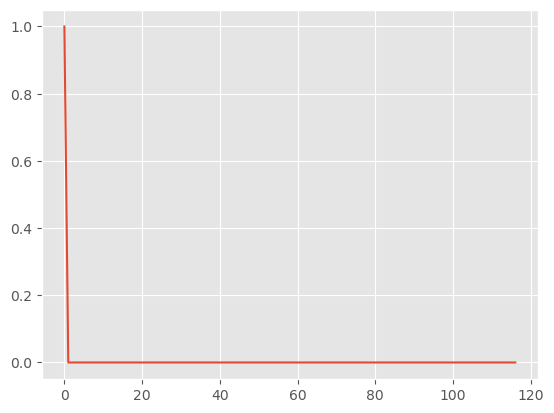

In [22]:
# Dataset label contain view
print(f"Dataset labels (view): {dataset[0].y[:10]}")
plt.plot(dataset[0].y)


## 5. Training Setup

In [23]:

def train_epoch():
    model.train() # Set model to training mode (enables dropout)
    total_loss = 0
    for data in train_loader: # Iterate in batches over graph scenarios
        data = data.to(device) # Move batch data to the device
        optimizer.zero_grad() # Clear gradients
        
        # Forward pass
        out_logits = model(data)
        
        # Calculate loss
        # Ensure labels (data.y) are also on the correct device
        loss = criterion(out_logits, data.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.num_graphs # Accumulate loss, weighted by number of graphs in batch
        
    return total_loss / len(train_loader.dataset) # Average loss per graph in the training set

def test_epoch(loader, debug_n_graphs=3):
    model.eval()
    total_loss = 0
    all_preds_indices = []
    all_labels_indices = []
    debug_examples = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            out_logits = model(data)

            # Sigmoid + Binarisation
            preds_prob = torch.sigmoid(out_logits)
            preds_bin = (preds_prob >= 0.5).float()

            # Calcul de la loss sur les probabilités
            loss = criterion(preds_prob, data.y)
            total_loss += loss.item() * data.num_graphs

            labels = data.y.cpu().numpy().astype(int)
            preds_bin_cpu = preds_bin.cpu().numpy()
            

            graph_list = data.to_data_list()
            num_edges_per_graph = [g.num_edges for g in graph_list]
            cumsum_edges = np.cumsum([0] + num_edges_per_graph)

            for i, (start, end) in enumerate(zip(cumsum_edges[:-1], cumsum_edges[1:])):
                graph_labels = labels[start:end]
                graph_preds = preds_bin_cpu[start:end]

                true_idx = np.argmax(graph_labels) if np.sum(graph_labels) > 0 else -1
                pred_idx = np.argmax(graph_preds) if np.sum(graph_preds) > 0 else -1

                all_labels_indices.append(true_idx)
                all_preds_indices.append(pred_idx)

                if len(debug_examples) < debug_n_graphs:
                    debug_examples.append({
                        "graph_idx": len(all_labels_indices)-1,
                        "pred_probs": np.round(preds_prob[start:end].cpu().numpy(), 3),
                        "pred_bin": graph_preds,
                        "true_labels": graph_labels,
                        "pred_leak_idx": pred_idx,
                        "true_leak_idx": true_idx,
                    })

    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels_indices, all_preds_indices)

    return avg_loss, accuracy, all_labels_indices, all_preds_indices


# --- Training Execution ---
train_losses = []
test_losses = []
test_accuracies = []

EPOCHS = 500

if model and train_loader and test_loader:
    print("\nStarting training...")
    try: # Encadrer la boucle d'entraînement pour attraper l'erreur si elle persiste
        progress_bar = tqdm(range(1, EPOCHS + 1), desc="Training Progress")
        for epoch in progress_bar:
            train_loss = train_epoch()
            # Utiliser la nouvelle fonction test_epoch
            test_loss, test_acc, _, _ = test_epoch(test_loader)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            
            # Update progress bar with current training loss
            progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Test Loss": f"{test_loss:.4f}", "Test Acc": f"{test_acc:.4f}"})
            
            # Print detailed metrics every 50 epochs or at the end
            # if epoch % 50 == 0 or epoch == EPOCHS:
            #     print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print("\nTraining finished.")
    except Exception as e:
        print("\n--- ERROR DURING TRAINING LOOP ---")
        import traceback
        traceback.print_exc()
        print("---------------------------------")

else:
    print("\nSkipping training because model or data loaders are not initialized.")


Starting training...


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s, Train Loss=1.3840, Test Loss=1.4360, Test Acc=0.0417]


Training finished.


## 7. Displays: Evaluation & Results

Visualize the training progress and evaluate the final model performance.

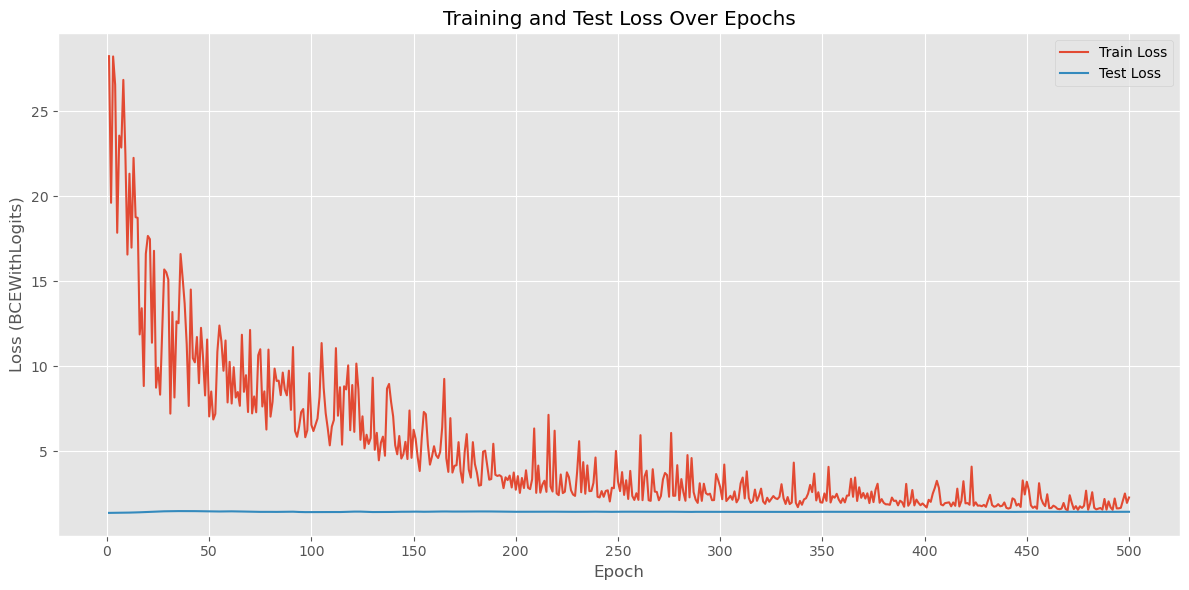

In [11]:
if train_losses and test_losses:
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    # plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', marker='o', linestyle='-')
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (BCEWithLogits)')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, EPOCHS + 1, max(1, EPOCHS // 10))) # Adjust x-ticks for readability
    plt.tight_layout()
    plt.show()
else:
    print("No training/test loss data to plot.")

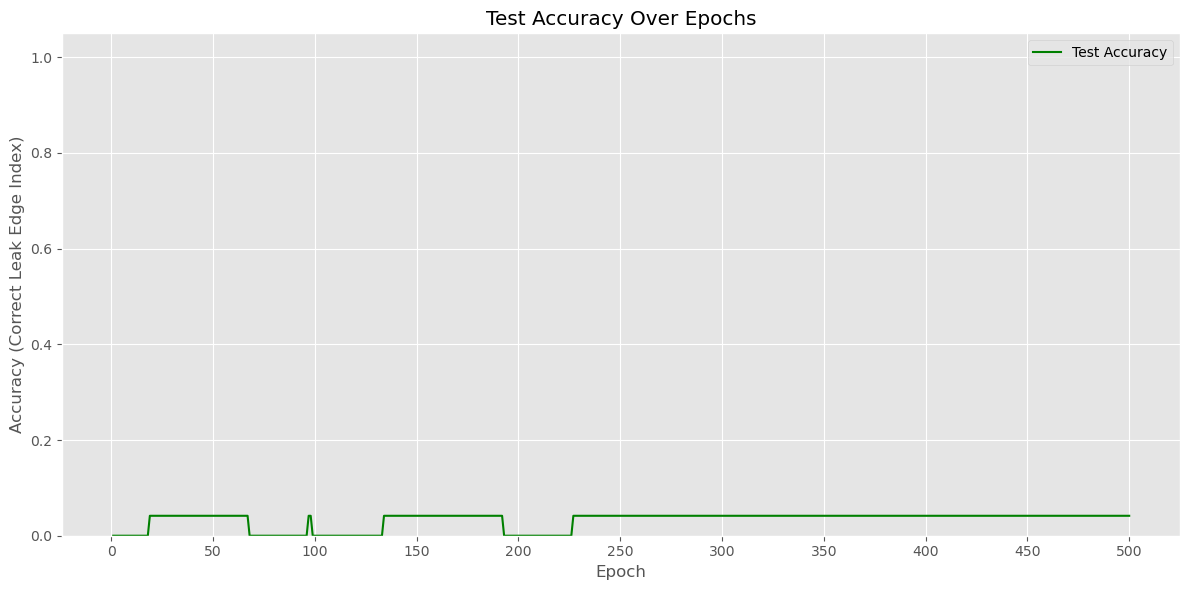

In [12]:
if test_accuracies:
    # Plot test accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, EPOCHS + 1), test_accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (Correct Leak Edge Index)')
    plt.title('Test Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05) # Accuracy ranges from 0 to 1
    plt.xticks(range(0, EPOCHS + 1, max(1, EPOCHS // 10)))
    plt.tight_layout()
    plt.show()
else:
    print("No test accuracy data to plot.")

In [24]:
# if model and test_loader:
#     print(f'\n--- Final Test Set Evaluation ---')
#     # Final evaluation on the test set
#     final_test_loss, final_test_acc, test_labels_indices, test_preds_indices = test_epoch(test_loader)
#     print(f'Final Test Loss: {final_test_loss:.4f}')
#     print(f'Final Test Accuracy (Correct Leak Edge Index ): {final_test_acc:.4f}')

#     # Detailed classification report (treating each edge index as a class)
#     # This compares the predicted leak index vs the true leak index for each graph.
#     # Useful for seeing if specific leaks (edge indices) are harder to predict.
#     try:
#         precision, recall, f1, support = precision_recall_fscore_support(
#             test_labels_indices, 
#             test_preds_indices, 
#             average='weighted', 
#             zero_division=0
#         )
#         print(f'\nWeighted Metrics (across all graphs):')
#         print(f'  Weighted Precision: {precision:.4f}')
#         print(f'  Weighted Recall: {recall:.4f}')
#         print(f'  Weighted F1-Score: {f1:.4f}')
        
#         # Also show metrics for the 'no leak' class (-1) if present
#         if -1 in test_labels_indices or -1 in test_preds_indices:
#              precision_nl, recall_nl, f1_nl, _ = precision_recall_fscore_support(
#                  test_labels_indices, 
#                  test_preds_indices, 
#                  labels=[-1], # Specifically for the 'no leak' class
#                  average='macro', # Since there's only one label here
#                  zero_division=0
#              )
#              print(f'  Metrics for No-Leak class (-1): P={precision_nl:.4f}, R={recall_nl:.4f}, F1={f1_nl:.4f}')
             
#     except Exception as e:
#         print(f"Could not calculate precision/recall/F1: {e}")

#     # Confusion Matrix (shows which edge index was predicted vs true)
#     try:
#         unique_labels_in_test = sorted(list(set(test_labels_indices + test_preds_indices)))
#         print(f"\nUnique leak indices involved in test set predictions: {len(unique_labels_in_test)}")
        
#         if len(unique_labels_in_test) < 35: # Only plot if reasonably small
#             cm = confusion_matrix(test_labels_indices, test_preds_indices, labels=unique_labels_in_test)
#             plt.figure(figsize=(max(8, len(unique_labels_in_test)//2), max(6, len(unique_labels_in_test)//2)))
#             sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#                         xticklabels=unique_labels_in_test, yticklabels=unique_labels_in_test)
#             plt.xlabel('Predicted Leaking Edge Index (within graph)')
#             plt.ylabel('True Leaking Edge Index (within graph)')
#             plt.title('Confusion Matrix (Leaking Edge Index)')
#             plt.tight_layout()
#             plt.show()
#         else:
#             print(f"\nConfusion matrix not plotted due to large number of unique edge indices ({len(unique_labels_in_test)}). Focus on accuracy and weighted metrics.")
#             # Optionally, print misclassified examples
#             misclassified_count = 0
#             print("\nExamples of Misclassified Leaks (True Index -> Predicted Index):")
#             for i in range(len(test_labels_indices)):
#                 if test_labels_indices[i] != test_preds_indices[i]:
#                     print(f"  Graph {i}: {test_labels_indices[i]} -> {test_preds_indices[i]}")
#                     misclassified_count += 1
#                     if misclassified_count >= 10: # Show first 10
#                         break
#             if misclassified_count == 0:
#                  print("  None found.")
                 
#     except Exception as e:
#         print(f"Could not generate confusion matrix: {e}")
# else:
#     print("\nSkipping final evaluation because model or test loader is not initialized.")

In [14]:
test_accuracies[0]

0.0

In [15]:
# model = None
# optimizer = None
# criterion = None
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# if dataset and len(dataset) > 0:
#     try:
#         # Determine input/output dimensions from data
#         num_node_features = dataset.num_node_features
#         num_edge_features = dataset.num_edge_features

#         model = GNNLeakDetector(num_node_features=num_node_features,
#                                 num_edge_features=num_edge_features,
#                                 hidden_channels=64).to(device) # Move model to device

#         optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4) # Add weight decay
#         # Use BCEWithLogitsLoss for binary classification per edge (leak or no leak)
#         # It expects raw logits as input and float labels (0.0 or 1.0)
#         # Calculate positive weight for potential class imbalance (many non-leaks vs one leak)
#         # This requires analyzing the labels across the dataset.
#         # Simple approximation: assume roughly num_edges non-leaks to 1 leak per graph
#         num_edges_per_graph = dataset[0].num_edges
#         pos_weight = torch.tensor([num_edges_per_graph - 1], dtype=torch.float).to(device) # Weight for the positive class (leak)
#         criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

#         print(f"\nModel initialized:\n{model}")
#         print(f"Number of node features: {num_node_features}")
#         print(f"Number of static edge features: {num_edge_features}")
#         print(f"Optimizer: {optimizer}")
#         print(f"Criterion: {criterion} with pos_weight={pos_weight.item():.2f}")

#     except Exception as e:
#         print(f"Error initializing model, optimizer, or criterion: {e}")
#         model = None # Ensure model is None if setup fails
# else:
#     print("\nCannot initialize model because the dataset is empty or failed to initialize.")

In [16]:
# model = None
# optimizer = None
# criterion = None
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# if dataset and len(dataset) > 0:
#     try:
#         # Determine input/output dimensions from data
#         num_node_features = dataset.num_node_features
#         num_edge_features = dataset.num_edge_features

#         model = GNNLeakDetector(num_node_features=num_node_features,
#                                 num_edge_features=num_edge_features,
#                                 hidden_channels=64).to(device) # Move model to device

#         optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4) # Add weight decay
#         # Use BCEWithLogitsLoss for binary classification per edge (leak or no leak)
#         # It expects raw logits as input and float labels (0.0 or 1.0)
#         # Calculate positive weight for potential class imbalance (many non-leaks vs one leak)
#         # This requires analyzing the labels across the dataset.
#         # Simple approximation: assume roughly num_edges non-leaks to 1 leak per graph
#         num_edges_per_graph = dataset[0].num_edges
#         pos_weight = torch.tensor([num_edges_per_graph - 1], dtype=torch.float).to(device) # Weight for the positive class (leak)
#         criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

#         print(f"\nModel initialized:\n{model}")
#         print(f"Number of node features: {num_node_features}")
#         print(f"Number of static edge features: {num_edge_features}")
#         print(f"Optimizer: {optimizer}")
#         print(f"Criterion: {criterion} with pos_weight={pos_weight.item():.2f}")

#     except Exception as e:
#         print(f"Error initializing model, optimizer, or criterion: {e}")
#         model = None # Ensure model is None if setup fails
# else:
#     print("\nCannot initialize model because the dataset is empty or failed to initialize.")

In [17]:
# model = None
# optimizer = None
# criterion = None
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# if dataset and len(dataset) > 0:
#     try:
#         # Determine input/output dimensions from data
#         num_node_features = dataset.num_node_features
#         num_edge_features = dataset.num_edge_features

#         model = GNNLeakDetector(num_node_features=num_node_features,
#                                 num_edge_features=num_edge_features,
#                                 hidden_channels=64).to(device) # Move model to device

#         optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4) # Add weight decay
#         # Use BCEWithLogitsLoss for binary classification per edge (leak or no leak)
#         # It expects raw logits as input and float labels (0.0 or 1.0)
#         # Calculate positive weight for potential class imbalance (many non-leaks vs one leak)
#         # This requires analyzing the labels across the dataset.
#         # Simple approximation: assume roughly num_edges non-leaks to 1 leak per graph
#         num_edges_per_graph = dataset[0].num_edges
#         pos_weight = torch.tensor([num_edges_per_graph - 1], dtype=torch.float).to(device) # Weight for the positive class (leak)
#         criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

#         print(f"\nModel initialized:\n{model}")
#         print(f"Number of node features: {num_node_features}")
#         print(f"Number of static edge features: {num_edge_features}")
#         print(f"Optimizer: {optimizer}")
#         print(f"Criterion: {criterion} with pos_weight={pos_weight.item():.2f}")

#     except Exception as e:
#         print(f"Error initializing model, optimizer, or criterion: {e}")
#         model = None # Ensure model is None if setup fails
# else:
#     print("\nCannot initialize model because the dataset is empty or failed to initialize.")

In [18]:
len(test_loader.dataset) * test_accuracies[0]

0.0